# MNIST Standard Biological Images: Keras Logistic Regression

In [154]:
import time
import re
import numpy as np
import pandas as pd
#import seaborn as sns  # for nicer plots
#sns.set(style="darkgrid")  # default style
import tensorflow as tf
from tensorflow import keras
from keras import metrics
import numpy as np
from tensorflow import keras
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras import layers, models, Input
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Activation
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
tf.get_logger().setLevel('INFO')

In [155]:
def display_confusion_matrix(y_tst, y_prd, ttl=None, sz=5, lbl=None):
    # Generate and display the confusion matrix
    cm = confusion_matrix(y_tst, y_prd)

    # Plot confusion matrix with labels
    fig, ax = plt.subplots(figsize=(sz,sz))
    
    if (lbl != None):
        im = ax.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
        ax.figure.colorbar(im, ax=ax)

        # Set labels and title
        ax.set_xlabel('Predicted labels')
        ax.set_ylabel('True labels')

        # Set tick labels
        ax.set_xticks(np.arange(len(lbl)))
        ax.set_yticks(np.arange(len(lbl)))
        ax.set_xticklabels(lbl)
        ax.set_yticklabels(lbl)

        # Rotate x-tick labels
        plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")

        # Add values to cells (optional)
        for i in range(cm.shape[0]):
            for j in range(cm.shape[1]):
                ax.text(j, i, format(cm[i, j], 'd'),
                        ha="center", va="center",
                        color="white" if cm[i, j] > cm.max() / 2. else "black")
    else:
        disp = ConfusionMatrixDisplay(confusion_matrix=cm)
        disp.plot(cmap=plt.cm.Blues, ax=ax)

    # Customize plot
    plt.title(ttl)
    plt.show()

In [156]:
def get_data_set_dimensions(contained_array, data):
    x_shape = data.shape
    end_of_range = len(x_shape)
    #print("end_of_range:", end_of_range)

    dim = ""
    if end_of_range == 4:
        if x_shape[3] == 3:
            dim = "RGB images:"
        else:
            dim = "3D images: "
        dim = dim + str(x_shape[1]) + "x" + str(x_shape[2]) + "x" + str(x_shape[3])
    elif end_of_range == 3:
        dim = "2D images: " + str(x_shape[1]) + "x" + str(x_shape[2])
    if (dim != ""):
        print(f"  {contained_array}: {x_shape[0]} {dim}")

    return end_of_range

In [157]:
def flatten_data(contained_array, data, end_of_range):
    data_shape = data.shape
    
    if (end_of_range > 2):
        # Handle 2D, 3D, ... nD image dimensions
        flat_sz = 1
        for ix in range(1, end_of_range):
            flat_sz = flat_sz * data_shape[ix]
        #print("flat_sz:", flat_sz)
        data = data.reshape(-1, flat_sz)
    else:
        # Convert label dimensions to 1D
        data = np.ravel(data, order='C')
    return(data)

## Load data then flatten labels, images are flattened later within LR model

In [158]:
def load_and_flatten(fn):
    npz_file = np.load(fn, allow_pickle=True)
    #print(fn, "arrays:", blood_npz.files)

    # Dictionaries to store flattened image data
    flat_arr = {}
    label_arr = {}
    # Dictionary to store images (unflattened)
    orig_arr = {}
    
    substr = "labels"

    for contained_array in npz_file.files:
        # Only labels need to be flattened.
        # Features (images) will be flattened by the Logistic Regression model
        end_of_range = get_data_set_dimensions(contained_array, npz_file[contained_array])
        match = re.search(substr, contained_array)
        if (match):
            #print(f"  BEFORE: {contained_array}: {npz_file[contained_array].shape}")
            arr = flatten_data(contained_array, npz_file[contained_array], end_of_range)
            label_arr[contained_array] = arr
            #print(f"  {contained_array} (flattened): {label_arr[contained_array].shape}")
        else:
            orig_arr[contained_array] = npz_file[contained_array]
    
    return orig_arr, label_arr

## Build a Keras Logistic Regression model using a single Dense layer

In [159]:
def build_model(n_classes,
                img_dim,
                hidden_layer_sizes=[],
                activation='relu',
                optimizer='adam',
                learning_rate=0.01):

    tf.keras.backend.clear_session()
    np.random.seed(0)
    tf.random.set_seed(0)

    # Keras logistic regression has input and output layers with as a single Dense layer.
    # So hidden_layer will be 0 for this model

    hidden_layers = len(hidden_layer_sizes)
    ix = 0
    model = keras.Sequential()
    model.add(keras.Input(shape=img_dim)),
    #model.add(Flatten(input_shape=(img_dim)))  # Flatten image
    model.add(Flatten())
    while(hidden_layers != 0):
        model.add(Dense(hidden_layer_sizes[ix], activation=activation))
        ix += 1
        hidden_layers -= 1
    model.add(Dense(n_classes, activation='softmax')) # Output layer with n-classes
    # Display the model summary to see the architecture
    model.summary()
    
    # Compile the model using the Adam optimizer
    #model.compile(optimizer='adam',
    model.compile(optimizer=optimizer,
                loss='sparse_categorical_crossentropy',
                #loss='categorical_crossentropy',
                metrics=['accuracy'],
            )
    return model


-------------------------------------------------------
bloodmnist.npz
  train_images: 11959 RGB images:28x28x3
  val_images: 1712 RGB images:28x28x3
  test_images: 3421 RGB images:28x28x3

Label:  7


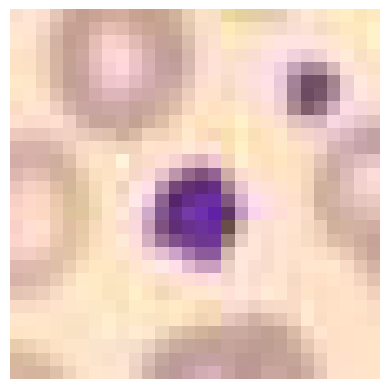

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ flatten (Flatten)                    │ (None, 2352)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 8)                   │          18,824 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 18,824 (73.53 KB)

 Trainable params: 18,824 (73.53 KB)

 Non-trainable params: 0 (0.00 B)

Training...


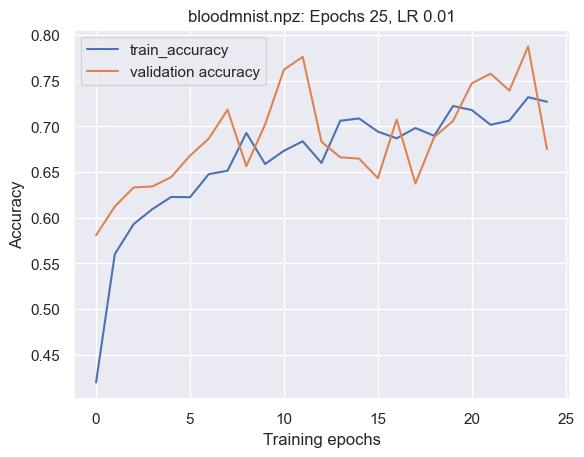

Training time: 5.0 seconds
Evaluation time: 0.08 seconds
Accuracy: 67.524, Loss: 24.10764, Epochs: 25
Training...


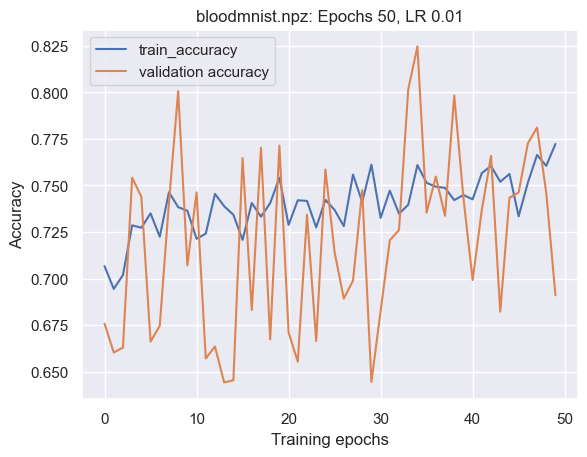

Training time: 9.94 seconds
Evaluation time: 0.09 seconds
Accuracy: 69.103, Loss: 35.01639, Epochs: 50
Training...


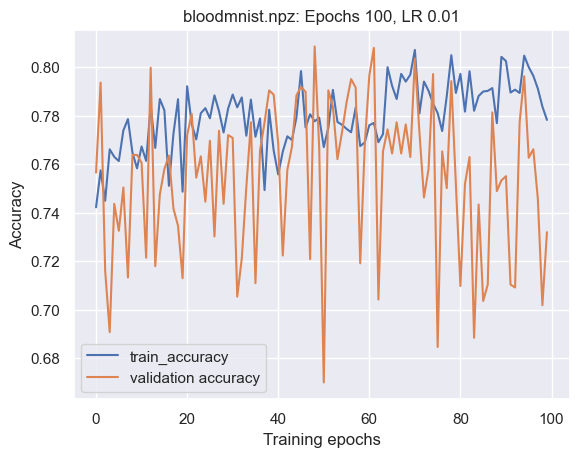

Training time: 20.32 seconds
Evaluation time: 0.11 seconds
Accuracy: 73.195, Loss: 34.31124, Epochs: 100
Training...


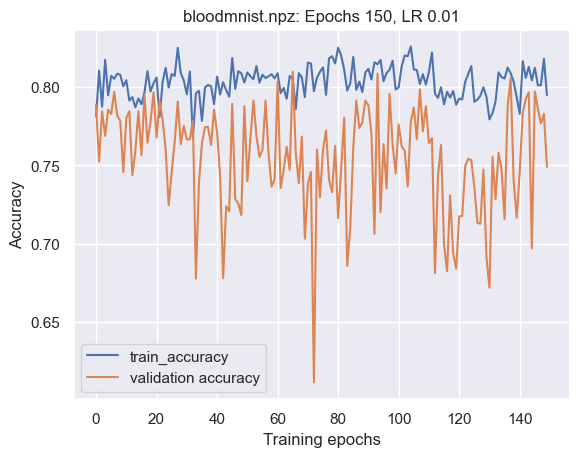

Training time: 32.11 seconds
Evaluation time: 0.1 seconds
Accuracy: 74.89, Loss: 35.94746, Epochs: 150

-------------------------------------------------------
breastmnist.npz
  train_images: 546 2D images: 28x28
  val_images: 78 2D images: 28x28
  test_images: 156 2D images: 28x28

Label:  1


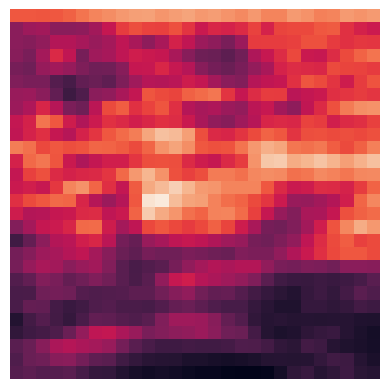

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ flatten (Flatten)                    │ (None, 784)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 2)                   │           1,570 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,570 (6.13 KB)

 Trainable params: 1,570 (6.13 KB)

 Non-trainable params: 0 (0.00 B)

Training...


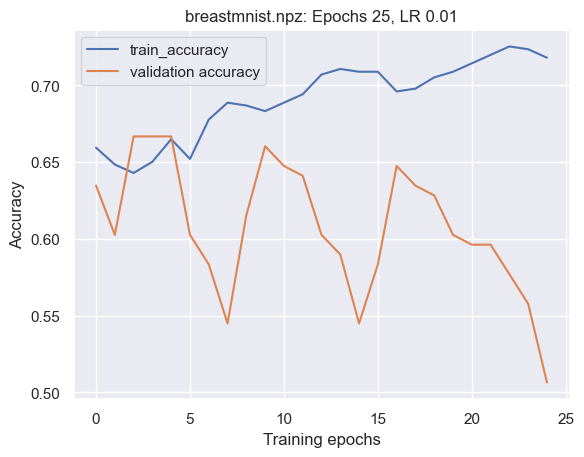

Training time: 2.95 seconds
Evaluation time: 0.29 seconds
Accuracy: 50.641, Loss: 17.85647, Epochs: 25
Training...


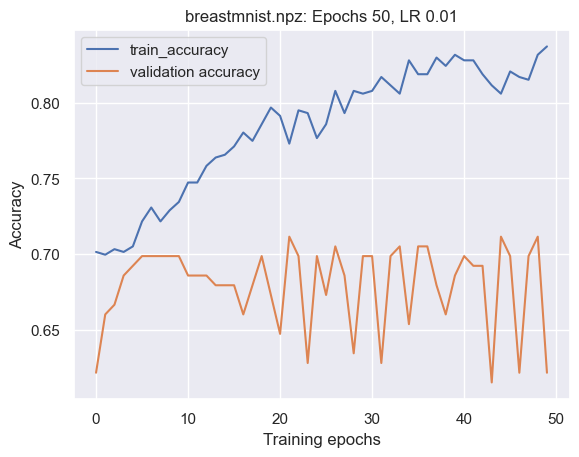

Training time: 5.8 seconds
Evaluation time: 0.25 seconds
Accuracy: 62.179, Loss: 7.13951, Epochs: 50
Training...


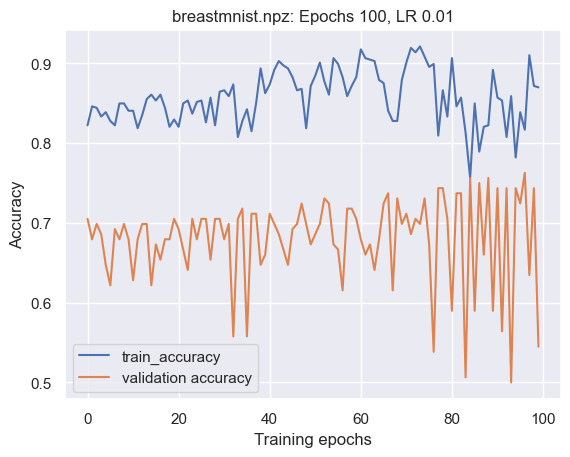

Training time: 12.73 seconds
Evaluation time: 0.31 seconds
Accuracy: 54.487, Loss: 10.03502, Epochs: 100
Training...


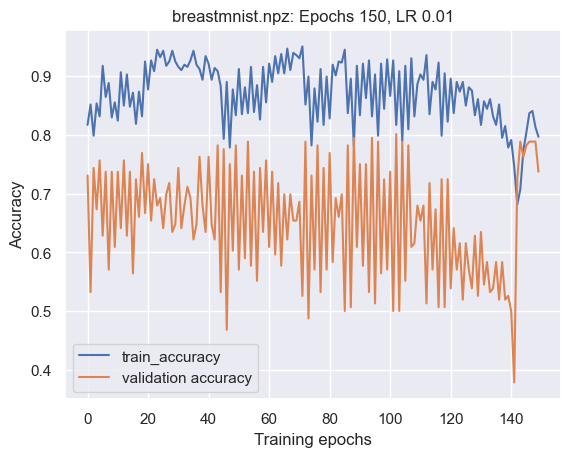

Training time: 19.38 seconds
Evaluation time: 0.23 seconds
Accuracy: 73.718, Loss: 7.09743, Epochs: 150

-------------------------------------------------------
dermamnist.npz
  train_images: 7007 RGB images:28x28x3
  val_images: 1003 RGB images:28x28x3
  test_images: 2005 RGB images:28x28x3

Label:  0


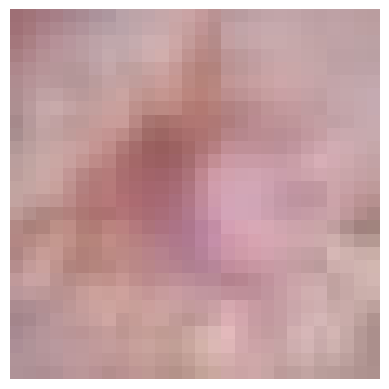

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ flatten (Flatten)                    │ (None, 2352)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 7)                   │          16,471 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 16,471 (64.34 KB)

 Trainable params: 16,471 (64.34 KB)

 Non-trainable params: 0 (0.00 B)

Training...


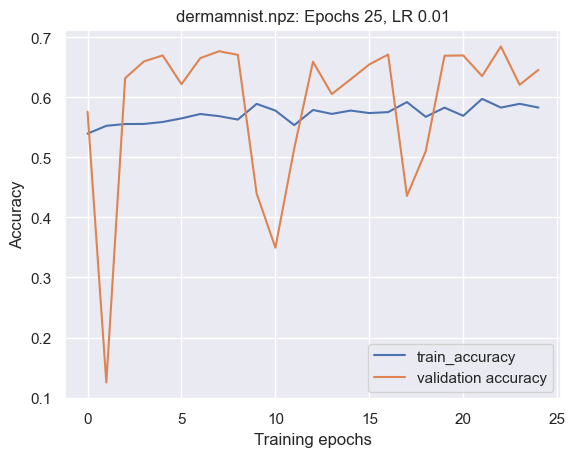

Training time: 3.88 seconds
Evaluation time: 0.07 seconds
Accuracy: 64.589, Loss: 61.06635, Epochs: 25
Training...


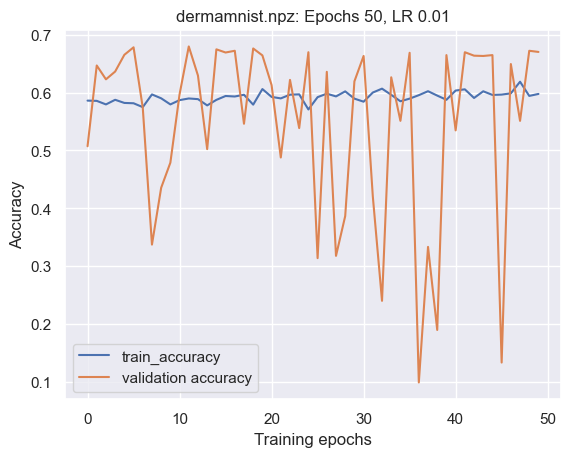

Training time: 7.54 seconds
Evaluation time: 0.3 seconds
Accuracy: 67.032, Loss: 31.07232, Epochs: 50
Training...


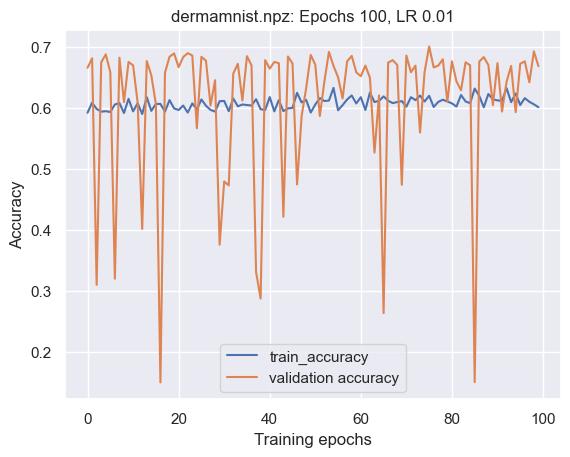

Training time: 13.58 seconds
Evaluation time: 0.27 seconds
Accuracy: 66.833, Loss: 30.84815, Epochs: 100
Training...


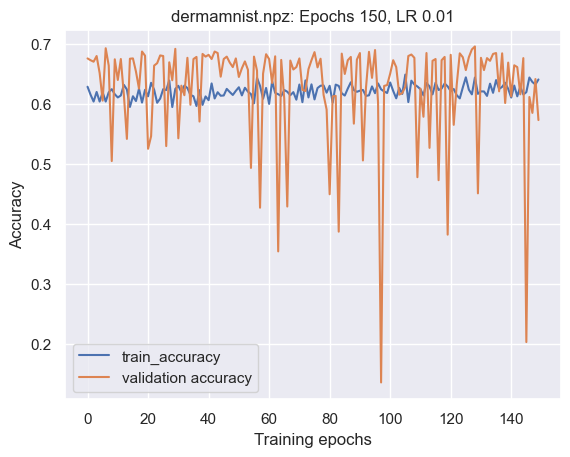

Training time: 22.77 seconds
Evaluation time: 0.21 seconds
Accuracy: 57.257, Loss: 63.53022, Epochs: 150

-------------------------------------------------------
octmnist.npz
  train_images: 97477 2D images: 28x28
  val_images: 10832 2D images: 28x28
  test_images: 1000 2D images: 28x28

Label:  0


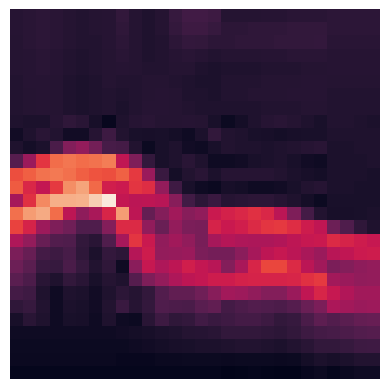

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ flatten (Flatten)                    │ (None, 784)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 4)                   │           3,140 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,140 (12.27 KB)

 Trainable params: 3,140 (12.27 KB)

 Non-trainable params: 0 (0.00 B)

Training...


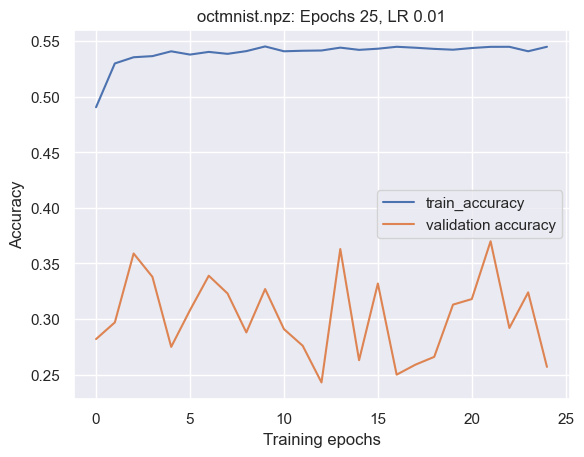

Training time: 20.7 seconds
Evaluation time: 0.14 seconds
Accuracy: 25.7, Loss: 13.46088, Epochs: 25
Training...


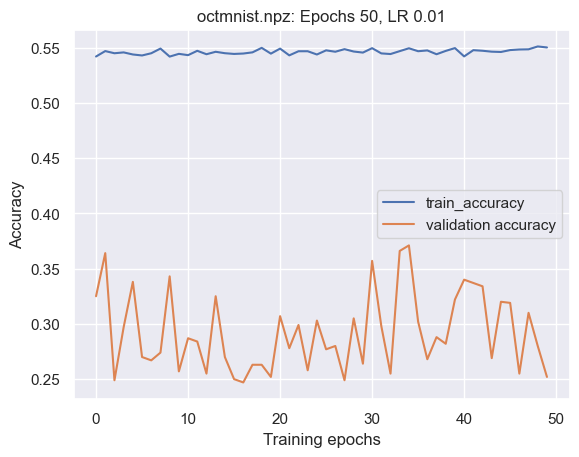

Training time: 41.85 seconds
Evaluation time: 0.06 seconds
Accuracy: 25.2, Loss: 13.4826, Epochs: 50
Training...


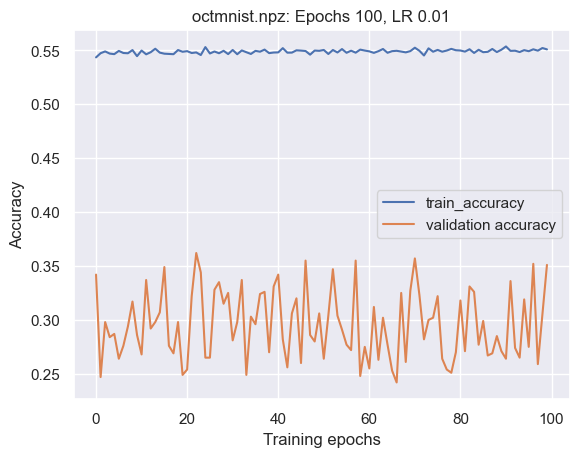

Training time: 83.51 seconds
Evaluation time: 0.06 seconds
Accuracy: 35.1, Loss: 9.09408, Epochs: 100
Training...


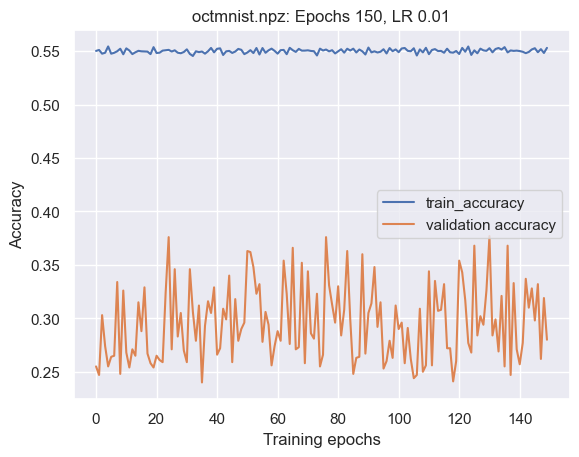

Training time: 125.16 seconds
Evaluation time: 0.15 seconds
Accuracy: 28.0, Loss: 10.3631, Epochs: 150

-------------------------------------------------------
organsmnist.npz
  train_images: 13932 2D images: 28x28
  val_images: 2452 2D images: 28x28
  test_images: 8827 2D images: 28x28

Label:  8


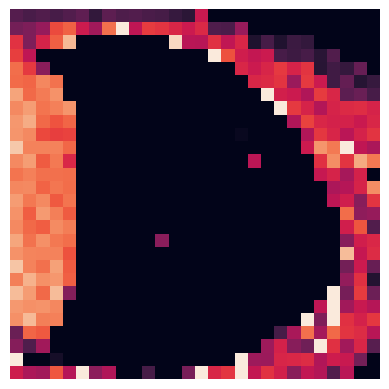

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ flatten (Flatten)                    │ (None, 784)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 11)                  │           8,635 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 8,635 (33.73 KB)

 Trainable params: 8,635 (33.73 KB)

 Non-trainable params: 0 (0.00 B)

Training...


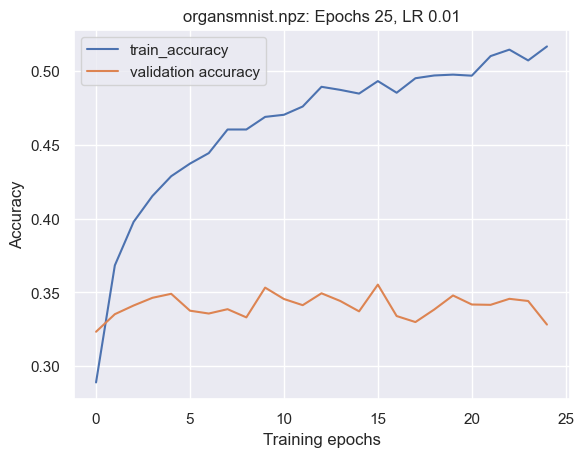

Training time: 5.86 seconds
Evaluation time: 0.17 seconds
Accuracy: 32.82, Loss: 34.11, Epochs: 25
Training...


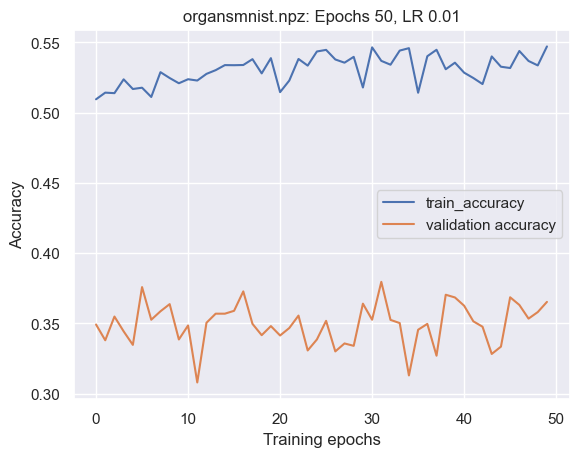

Training time: 11.21 seconds
Evaluation time: 0.23 seconds
Accuracy: 36.536, Loss: 33.94515, Epochs: 50
Training...


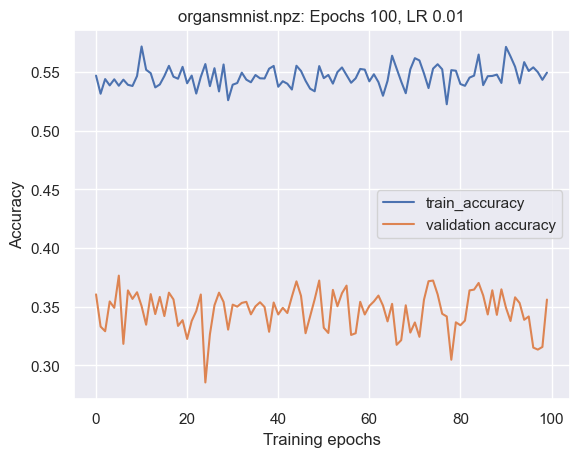

Training time: 22.39 seconds
Evaluation time: 0.24 seconds
Accuracy: 35.607, Loss: 39.32478, Epochs: 100
Training...


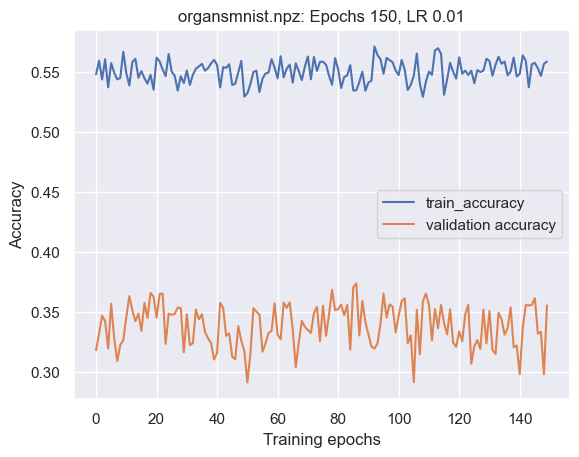

Training time: 33.86 seconds
Evaluation time: 0.26 seconds
Accuracy: 35.527, Loss: 39.01614, Epochs: 150

-------------------------------------------------------
nodulemnist3d.npz
  train_images: 1158 3D images: 28x28x28
  val_images: 165 3D images: 28x28x28
  test_images: 310 3D images: 28x28x28

Label:  0


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ flatten (Flatten)                    │ (None, 21952)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 2)                   │          43,906 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 43,906 (171.51 KB)

 Trainable params: 43,906 (171.51 KB)

 Non-trainable params: 0 (0.00 B)

Training...


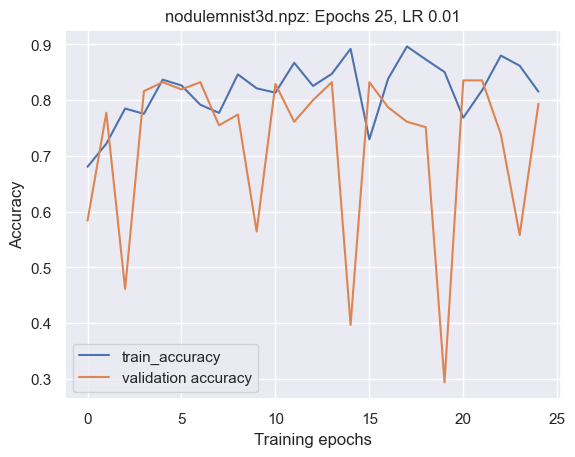

Training time: 1.91 seconds
Evaluation time: 0.14 seconds
Accuracy: 79.355, Loss: 75.02581, Epochs: 25
Training...


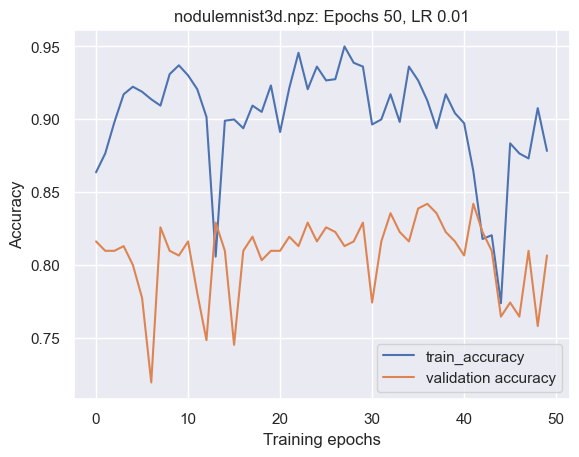

Training time: 3.47 seconds
Evaluation time: 0.07 seconds
Accuracy: 80.645, Loss: 117.17525, Epochs: 50
Training...


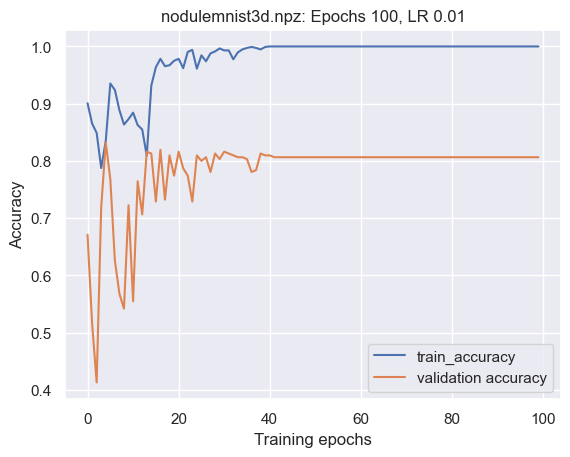

Training time: 6.75 seconds
Evaluation time: 0.15 seconds
Accuracy: 80.645, Loss: 106.39817, Epochs: 100
Training...


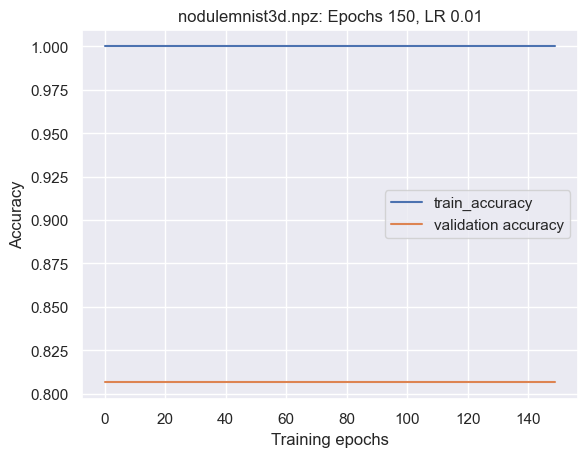

Training time: 9.65 seconds
Evaluation time: 0.11 seconds
Accuracy: 80.645, Loss: 106.39817, Epochs: 150

-------------------------------------------------------
organmnist3d.npz
  train_images: 971 3D images: 28x28x28
  val_images: 161 3D images: 28x28x28
  test_images: 610 3D images: 28x28x28

Label:  3


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ flatten (Flatten)                    │ (None, 21952)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 11)                  │         241,483 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 241,483 (943.29 KB)

 Trainable params: 241,483 (943.29 KB)

 Non-trainable params: 0 (0.00 B)

Training...


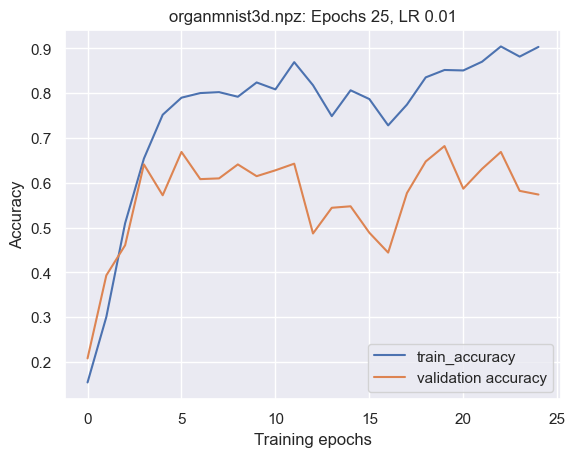

Training time: 2.13 seconds
Evaluation time: 0.15 seconds
Accuracy: 57.377, Loss: 235.60802, Epochs: 25
Training...


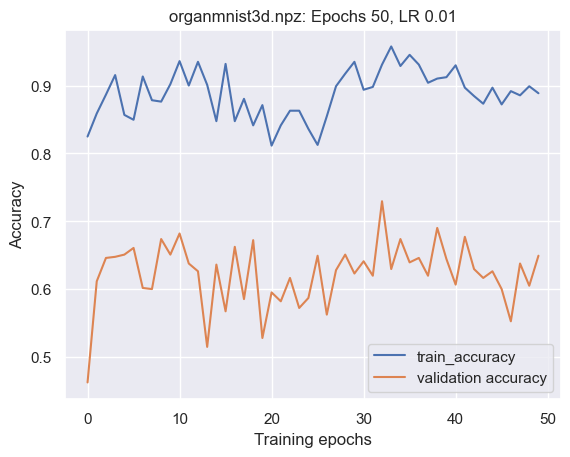

Training time: 3.56 seconds
Evaluation time: 0.07 seconds
Accuracy: 64.918, Loss: 423.40652, Epochs: 50
Training...


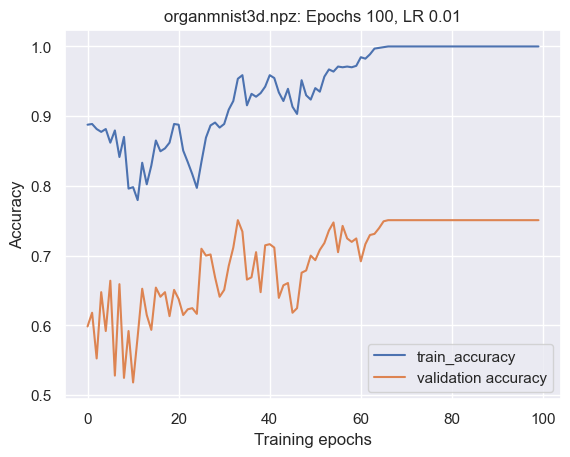

Training time: 7.07 seconds
Evaluation time: 0.07 seconds
Accuracy: 75.082, Loss: 380.36444, Epochs: 100
Training...


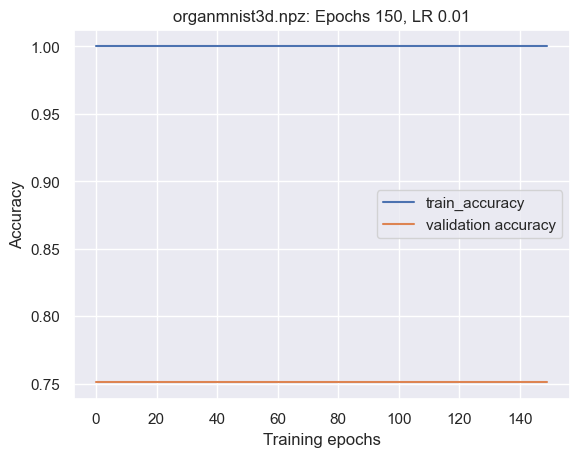

Training time: 10.69 seconds
Evaluation time: 0.07 seconds
Accuracy: 75.082, Loss: 380.36444, Epochs: 150

-------------------------------------------------------
retinamnist_128.npz
  train_images: 1080 RGB images:128x128x3
  val_images: 120 RGB images:128x128x3
  test_images: 400 RGB images:128x128x3

Label:  0


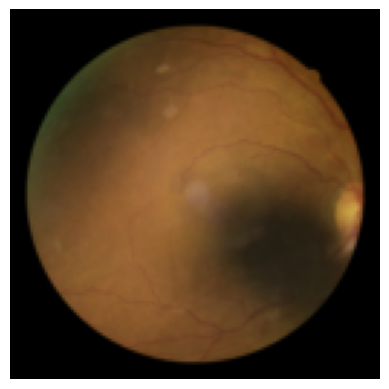

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ flatten (Flatten)                    │ (None, 49152)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 5)                   │         245,765 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 245,765 (960.02 KB)

 Trainable params: 245,765 (960.02 KB)

 Non-trainable params: 0 (0.00 B)

Training...


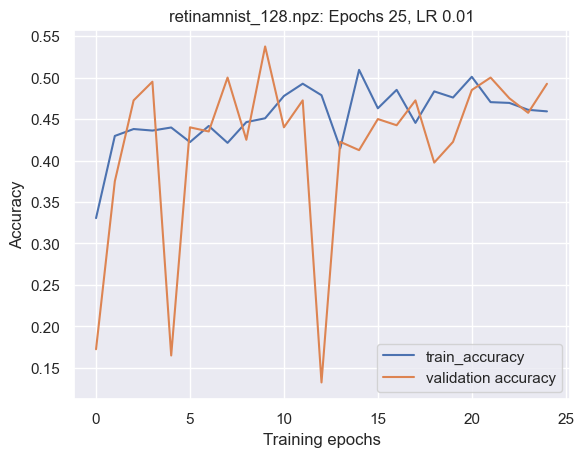

Training time: 2.24 seconds
Evaluation time: 0.06 seconds
Accuracy: 49.25, Loss: 390.22128, Epochs: 25
Training...


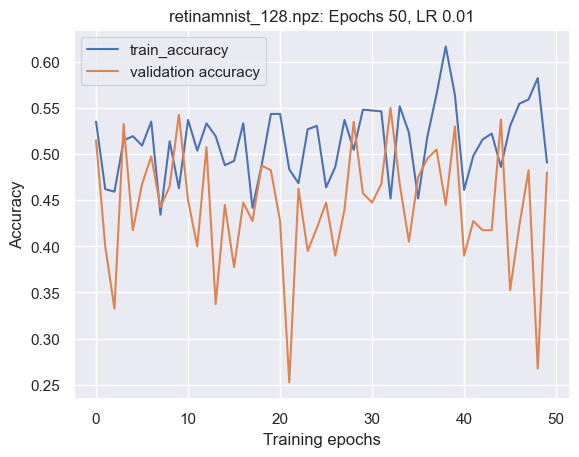

Training time: 3.92 seconds
Evaluation time: 0.1 seconds
Accuracy: 48.0, Loss: 173.7113, Epochs: 50
Training...


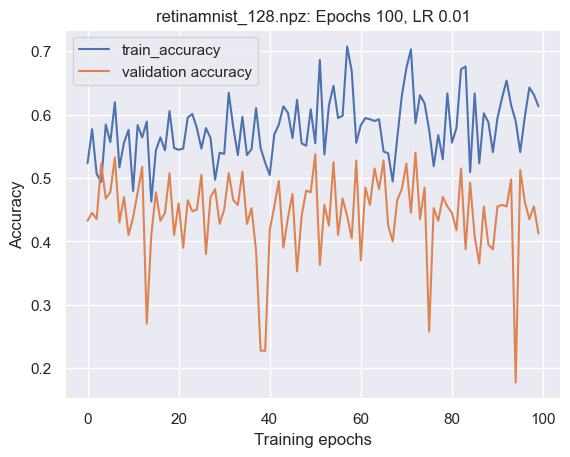

Training time: 7.81 seconds
Evaluation time: 0.06 seconds
Accuracy: 41.25, Loss: 255.90302, Epochs: 100
Training...


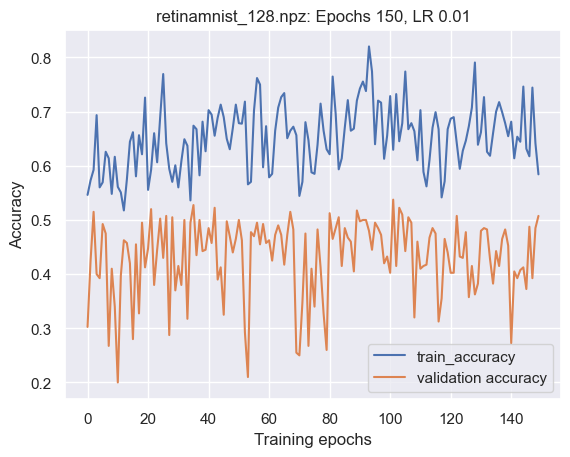

Training time: 11.76 seconds
Evaluation time: 0.22 seconds
Accuracy: 50.75, Loss: 344.45544, Epochs: 150
DONE


In [160]:
# NOTE: 'chestmnist.npz', # image, label size length mismatch, not used here
files = ['bloodmnist.npz', 'breastmnist.npz', 'dermamnist.npz', 'octmnist.npz', 'organsmnist.npz', \
         'nodulemnist3d.npz', 'organmnist3d.npz', 'retinamnist_128.npz']
#files = ['bloodmnist.npz', 'breastmnist.npz']

for fn in files:
    print("\n-------------------------------------------------------")
    print(fn)
    original_imgs, labels = load_and_flatten(fn)
    feature_keys = list(original_imgs.keys())
    #print(feature_keys)
    label_keys = list(labels.keys())
    #print(label_keys)
    
    img_shape = original_imgs[feature_keys[0]].shape
    img_dim = []
    for ix in range(1, len(img_shape)):
        img_dim.append(img_shape[ix])
    #print("img_dim:", img_dim)

    X_train = original_imgs[feature_keys[0]]
    y_train = labels[label_keys[0]]
    X_test = original_imgs[feature_keys[2]]
    y_test = labels[label_keys[2]]

    # Find number of unique classes within data set
    class_cnt, value_cnts = np.unique(labels[label_keys[0]], return_counts=True)
    #print(f"class_cnt: {class_cnt}")
    #print(f"value_cnts: {value_cnts}")
    n_classes = len(class_cnt)
    #print(f"n_classes: {n_classes}")

    # Display the first image and label in the training data
    print("\nLabel: ", y_train[0])
    if len(img_dim) < 3 or img_dim[2] == 3:
        #img_arr = original_imgs[feature_keys[0]]
        img = X_train[0]
        plt.imshow(img)
        plt.axis('off')
        plt.show()

    # Build the Keras Logistic Regression Model
    learning_rate = 0.01
    kerasLR = build_model(n_classes, img_dim, [], 'relu', 'adam', learning_rate)

    # Test training with a variety of epochs for each data set
    #for num_epochs in [25, 50]:
    for num_epochs in [25, 50, 100, 150]:
    
        # Train the Logistic Regression model.
        print('Training...')
        start = time.time()
        history = kerasLR.fit(
                x=X_train,
                y=y_train,
                epochs=num_epochs,
                batch_size=64,
                validation_split=0.1,
                validation_data=(X_test, y_test),
                verbose=0)
        trn_elapsed = time.time() - start

        ttl = fn + ": Epochs " + str(num_epochs) + ", LR " + str(learning_rate)
        train_accuracy = history.history['accuracy']
        val_accuracy = history.history['val_accuracy']
        plt.plot(train_accuracy, label='train_accuracy')
        plt.plot(val_accuracy, label='validation accuracy')
        #plt.xticks(range(num_epochs))
        plt.xlabel('Training epochs')
        plt.ylabel('Accuracy')
        plt.title(ttl)
        plt.legend()
        plt.show()

        # Evaluate the model and determine final accuracy
        start = time.time()
        #test_accuracy = kerasLR.evaluate(x=X_test, y=y_test, verbose=0,
        #                             return_dict=True)['accuracy']
        loss, test_accuracy = kerasLR.evaluate(x=X_test, y=y_test, verbose=0)
        eval_elapsed = time.time() - start
        
        print(f"Training time: {round(trn_elapsed, 2)} seconds")
        print(f"Evaluation time: {round(eval_elapsed, 2)} seconds")
        print(f"Accuracy: {round(test_accuracy * 100, 3)}, Loss: {round(loss, 5)}, Epochs: {num_epochs}")
print("DONE")